## Exercise 1

### Part (a)

$$ dx = \text{tanh}(x) dt + d\beta $$

In [107]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import scipy.stats as stats

In [49]:
def gaussian_integral_grid(m, K, a, N):
    
    D = m.shape[0]
    
    m = np.expand_dims(m, axis=tuple(np.arange(1, D+1)))
    Kchol = np.linalg.cholesky(K)
    
    grid = np.meshgrid(*list([np.linspace(-a, a, N) for i in range(D)]))
    grid = np.stack(grid, axis=0)
    
    scaled_grid = m + np.einsum('ij, j... -> i...', Kchol, grid)
    weights = np.exp(np.sum(-0.5 * grid ** 2, axis=0))
    weights = weights * (2 * np.pi) ** - (D / 2)
    weights = weights * (2 * a / (N - 1)) ** D
    
    return scaled_grid, weights


def gaussian_integral(function, t, G, m, K, a, N):
    
    grid, weights = gaussian_integral_grid(m, K, a, N)
    
    grid_axes = tuple(np.arange(G))
    sum_axes = tuple(np.arange(G, len(weights.shape)+G))
    
    weights = np.expand_dims(weights, axis=grid_axes)
    f = function(x=grid, t=t)
    integral = np.sum(f * weights, axis=sum_axes)
    
    return integral

In [50]:
def benes():
    
    def f(x, t):
        return np.tanh(x)
    
    def L(x, t):
        
        M = len(x.shape)
        I = np.eye(x.shape[0])
        I = np.expand_dims(I, axis=tuple(np.arange(2, M+1)))
        
        I = np.tile(I, (1,) + x.shape[1:])
        
        return I
    
    
    def fjac(x, t):
        
        return np.apply_along_axis(np.diag, 0, np.cosh(x) ** -2)
    
    
    def LQLT(x, t):
        
        L_ = L(x, t)
        
        return np.einsum('ij..., kj... -> ik...', L_, L_)
    
    return f, L, fjac, LQLT

In [57]:
def gaussian_ode_dynamics(y, t, f, fjac, LQLT, D, a, N):
    
    m = y[:D]
    P = np.reshape(y[D:], (D, D))
    
    dm = gaussian_integral(function=f, t=t, G=1, m=m, K=P, a=a, N=N)
    
    EF = gaussian_integral(function=fjac, t=t, G=2, m=m, K=P, a=a, N=N)
    ELQLT = gaussian_integral(function=LQLT, t=t, G=2, m=m, K=P, a=a, N=N)
    
    dP = P @ EF.T + EF @ P + ELQLT
    
    dy = np.concatenate([dm, dP.reshape((-1,))], axis=0)
    
    return dy

In [58]:
f, L, fjac, LQLT = benes()

In [59]:
D = 2
m = np.ones(shape=(D,))
K = 1. * np.eye(D)
a = 3.
N = 50

gaussian_integral(L, 1., 2, m, K, a, N)

array([[0.99562421, 0.        ],
       [0.        , 0.99562421]])

In [60]:
D = 1
m0 = np.zeros(shape=(D,))
P0 = 1e-6 * np.eye(D)
a = 3.
N = 50

y0 = np.concatenate([m0, P0.reshape((-1,))], axis=0)
t = np.linspace(0., 5., 100)

f, L, fjac, LQLT = benes()

sol = odeint(gaussian_ode_dynamics, y0, t, args=(f, fjac, LQLT, D, a, N))

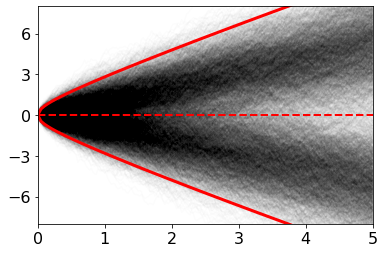

In [412]:
m = sol[:, 0]
std = sol[:, 1] ** 0.5

t_sim = np.load('../ch8/simulated_benes_t.npy')
x_sim = np.load('../ch8/simulated_benes_x.npy')

plt.plot(t, m, '--', color='red', zorder=2, linewidth=2)
plt.plot(t, m - 2 * std, color='red', zorder=2, linewidth=3)
plt.plot(t, m + 2 * std, color='red', zorder=2, linewidth=3)
plt.plot(t_sim, x_sim.T, color='k', alpha=0.01, zorder=1)
plt.xticks(np.linspace(0, 5, 6), fontsize=16)
plt.yticks(np.linspace(-6, 6, 5), fontsize=16)
plt.xlim([0, 5])
plt.ylim([-8, 8])
plt.show()

### Part (b)

In [415]:
def black_scholes(c, g):
    
    def f(x, t):
        return -c * x
    
    def L(x, t):
        return np.apply_along_axis(np.diag, 0, g * x)
    
    
    def fjac(x, t):
        return np.apply_along_axis(np.diag, 0, -c * np.ones_like(x))
    
    
    def LQLT(x, t):
        
        L_ = L(x, t)
        
        LQLT = np.einsum('ij..., kj... -> ik...', L_, L_)
        
        return LQLT
    
    return f, L, fjac, LQLT

In [55]:
def gaussian_ode_dynamics(y, t, f, fjac, LQLT, D, a, N):
    
    m = y[:D]
    P = np.reshape(y[D:], (D, D))
    
    dm = gaussian_integral(function=f, t=t, G=1, m=m, K=P, a=a, N=N)
    
    EF = gaussian_integral(function=fjac, t=t, G=2, m=m, K=P, a=a, N=N)
    ELQLT = gaussian_integral(function=LQLT, t=t, G=2, m=m, K=P, a=a, N=N, verbose=True)
    
    dP = P @ EF.T + EF @ P + ELQLT
    
    dy = np.concatenate([dm, dP.reshape((-1,))], axis=0)
    
    return dy

def gaussian_integral(function, t, G, m, K, a, N, verbose=False):
    
    grid, weights = gaussian_integral_grid(m, K, a, N)
    
    grid_axes = tuple(np.arange(G))
    sum_axes = tuple(np.arange(G, len(weights.shape)+G))
    
    weights = np.expand_dims(weights, axis=grid_axes)
    f = function(x=grid, t=t)
    integral = np.sum(f * weights, axis=sum_axes)
    
    return integral

In [421]:
D = 1
m0 = np.ones(shape=(D,))
P0 = 1e-6 * np.eye(D)
a = 2.
N = 50

c = 1e-1
g = 1e-1

y0 = np.concatenate([m0, P0.reshape((-1,))], axis=0)
t = np.linspace(0., 1., 100)

f, L, fjac, LQLT = black_scholes(c, g)

sol = odeint(gaussian_ode_dynamics, y0, t, args=(f, fjac, LQLT, D, a, N))

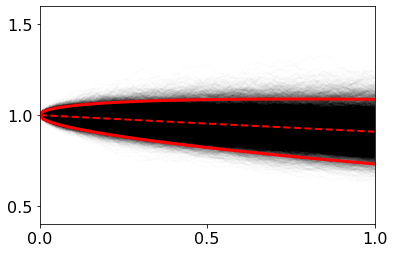

In [427]:
m = sol[:, 0]
std = sol[:, 1] ** 0.5

t_sim = np.load('../ch8/simulated_bs_t.npy')
x_sim = np.load('../ch8/simulated_bs_x.npy')

plt.plot(t, m, '--', color='red', zorder=2, linewidth=2)
plt.plot(t, m - 2 * std, color='red', zorder=2, linewidth=3)
plt.plot(t, m + 2 * std, color='red', zorder=2, linewidth=3)
plt.plot(t_sim, x_sim.T, color='k', alpha=0.01, zorder=1)
plt.xticks(np.linspace(0, 1, 3), fontsize=16)
plt.yticks(np.linspace(0.5, 1.5, 3), fontsize=16)
plt.xlim([0., 1.])
plt.ylim([0.4, 1.6])
plt.show()

## Exercise 3

The Shoji-Ozaki linearisation method approximates the SDE

$$ dx = f(x, t) dt + d\beta $$

with the linear SDE

$$\begin{align}
dx &= Gxdt + atdt + bdt + d\beta,\\
\\
G &= \frac{\partial f}{\partial x},\\
a &= \frac{\partial f}{\partial t} + \frac{q}{2} \frac{\partial^2 f}{\partial x^2}, \\
b &= f(x_0, t_0) - \frac{\partial f}{\partial x} x_0 - \left[ \frac{\partial f}{\partial t} + \frac{q}{2} \frac{\partial^2 f}{\partial x^2} \right]t_0.
\end{align}$$

Here we appy it to the SDE

$$ dx = \sin x dt + d\beta, $$

where $\beta$ is the standard Wiener process.

In [68]:
def sine_model():
    
    def f(x, t):
        return np.sin(x)
    
    def dft(x, t):
        return 0.
    
    def dfx(x, t):
        return np.cos(x)
    
    def ddfx(x, t):
        return - np.sin(x)
    
    def L(x, t):
        return np.array([[1.]])
    
    def LQLT(x, t):
        return np.array([[1.]])
    
    return f, dft, dfx, ddfx, L, LQLT

In [101]:
def shoji_ozaki(f, dft, dfx, ddfx, q, x0, t0, t1, N):
    
    dt = (t1 - t0) / N
    x = x0
    t = t0
    
    ts = [t]
    xs = [x]
    
    for i in range(N-1):
        
        G = dfx(x, t)
        a = dft(x, t) + 0.5 * q * ddfx(x, t)
        b = f(x, t) - dfx(x, t) * x - (dft(x, t) + 0.5 * q * ddfx(x, t)) * t
        
        dW = np.random.normal(loc=0., scale=dt ** 0.5)
        
        dx = G * x * dt + a * t * dt + b * dt + dW
        
        x = x + dx
        t = t + dt
        
        ts.append(t)
        xs.append(x)
        
    return np.array(ts), np.array(xs)

In [102]:
np.random.seed(0)

f, dft, dfx, ddfx, L, LQLT = sine_model()

q = 1.
x0 = 0.
t0 = 0.
t1 = 5.
N = 100

X = np.zeros(shape=(0, N))

for i in range(1000):
    
    t, x = shoji_ozaki(f, dft, dfx, ddfx, q, x0, t0, t1, N)
    X = np.concatenate([X, x[None, :]], axis=0)

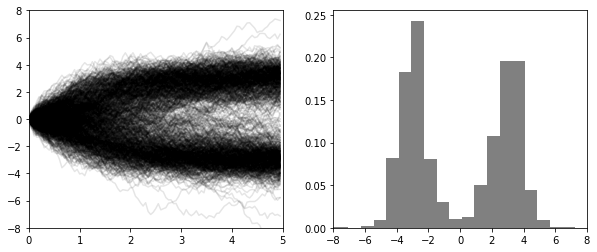

In [103]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(t, X.T, color='k', alpha=0.1)
plt.xlim([0, 5])
plt.ylim([-8, 8])

plt.subplot(1, 2, 2)
plt.hist(X[:, -1], color='gray', density=True, bins=20)
plt.xlim([-8, 8])

plt.show()

In [104]:
def cubature_grid(m, K):
    
    D = m.shape[0]
    
    m = np.expand_dims(m, axis=tuple(np.arange(1, D+1)))
    Kchol = np.linalg.cholesky(K)
    
    grid = np.concatenate([np.eye(D), -np.eye(D)], axis=1)
    
    scaled_grid = m + np.einsum('ij, jk -> ik', Kchol, grid)
    weights = np.ones(shape=(2 * D,)) / (2 * D)
    
    return scaled_grid, weights, Kchol


def cubature_ode_dynamics(y, t, f, LQLT, D):
    
    m = y[:D]
    P = np.reshape(y[D:], (D, D))
    
    grid, weights, Kchol = cubature_grid(m=m, K=P)
    
    fgrid = f(x=grid, t=t)
    
    dm = np.sum(fgrid * weights[None, :], axis=-1)
    
    dP = (weights[None, :] * fgrid) @ (Kchol @ grid).T
    dP = dP + dP.T
    dP = np.sum(LQLT(x=grid, t=t) * weights[None, None, :], axis=-1)
    
    dy = np.concatenate([dm, dP.reshape((-1,))], axis=0)
    
    return dy

In [124]:
D = 1
m0 = np.zeros(shape=(D,))
P0 = 1e-6 * np.eye(D)

q = 1.
x0 = 0.
t0 = 0.
t1 = 5.
N = 100

y0 = np.concatenate([m0, P0.reshape((-1,))], axis=0)
f, _, _, _, L, LQLT = sine_model()
t = np.linspace(t0, t1, N)

sol = odeint(cubature_ode_dynamics, y0, t, args=(f, LQLT, D))

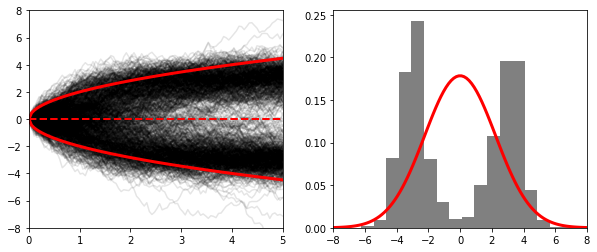

In [125]:
m = sol[:, 0]
std = sol[:, 1] ** 0.5

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(t, X.T, color='k', alpha=0.1)
plt.plot(t, m, '--', color='red', zorder=2, linewidth=2)
plt.plot(t, m - 2 * std, color='red', zorder=2, linewidth=3)
plt.plot(t, m + 2 * std, color='red', zorder=2, linewidth=3)
plt.xlim([0, 5])
plt.ylim([-8, 8])

plt.subplot(1, 2, 2)
x_pdf = np.linspace(-8, 8, 100)
plt.hist(X[:, -1], color='gray', density=True, bins=20)
plt.plot(x_pdf, stats.norm.pdf(x_pdf, m[-1], std[-1]), color='red', zorder=2, linewidth=3)
plt.xlim([-8, 8])

plt.show()

## Exercise 5

In [146]:
def pathwise_series_dynamics(x, t, f, L, z, T, M):
    
    """
    Assumes the SDE is scalar.
    """
    
    M = np.arange(1, M+1)
    
    phi = np.cos((2 * M - 1) * np.pi / (2 * T) * t)
    
    return f(x, t) + L(x, t) @ np.reshape(np.sum(z * phi), (-1,))

In [168]:
q = 1.
x0 = np.array([0.])
t0 = 0.
t1 = 5.
N = 100

f, _, _, _, L, LQLT = sine_model()
t = np.linspace(t0, t1, N)
T = t1 - t0
M = 100

X = np.stack([odeint(pathwise_series_dynamics,
                     x0,
                     t,
                     args=(f, L, np.random.normal(size=(M,)), T, M))[:, 0]
              for i in range(1000)], axis=-1)

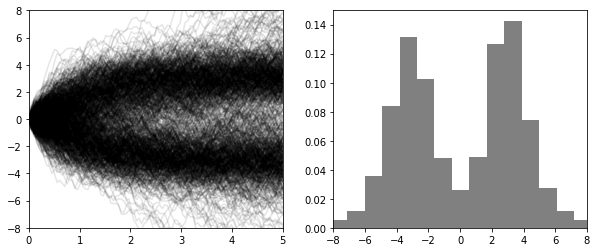

In [171]:
m = sol[:, 0]
std = sol[:, 1] ** 0.5

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(t, X, color='k', alpha=0.1)
plt.xlim([0, 5])
plt.ylim([-8, 8])

plt.subplot(1, 2, 2)
x_pdf = np.linspace(-8, 8, 100)
plt.hist(X[-1, :], color='gray', density=True, bins=20)
plt.xlim([-8, 8])

plt.show()